# Características Geométricas del Perfil
------------------------------------------
+ Objetivos: sobre la imagen de bloques encontrar los parámetros de área, perímetro, orientación y sus contornos.

In [ ]:
!pip install opencv-python

In [1]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline
#%matplotlib

# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt

#### Leemos la imagen

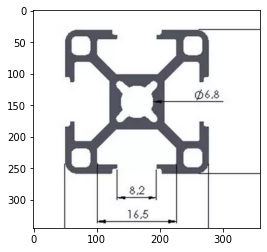

In [2]:
img = cv.imread('plot_perfil.png')
imgRGB =cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.figure("Imagen original")
plt.imshow(imgRGB)
plt.show()

## Recorte para referencia de medidas
+ Definimos Field of view(fov) para centrarnos en el segmento que posee la referencia

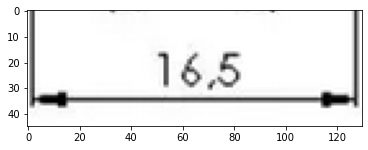

In [3]:
fov_ref = imgRGB[300:380,100:230]
fov_ref_gray=cv.cvtColor(fov_ref, cv.COLOR_RGB2GRAY )

plt.figure("FOV")
plt.imshow(fov_ref_gray,cmap='gray')
plt.show()

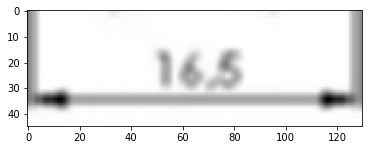

In [4]:
c_ref = cv.GaussianBlur(fov_ref_gray,(5,5),2)

plt.figure("Gaussiana")
plt.imshow(c_ref,cmap="gray")
plt.show()

## Detecto bordes con canny

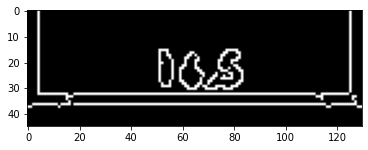

In [5]:
low_threshold = 50
high_threshold = 200
edges = cv.Canny(c_ref, low_threshold, high_threshold)

plt.figure("Canny")
plt.imshow(edges, cmap="gray")
plt.show()

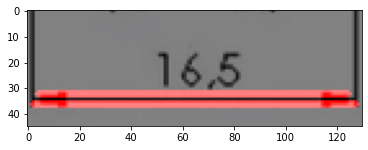

In [6]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100  # minimum number of pixels making up a line
max_line_gap = 10  # maximum gap in pixels between connectable line segments
line_image = np.copy(fov_ref) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv.line(line_image,(x1,y1),(x2,y2),(255,0,0),2)
    
# Draw the lines on the  image
lines_edges = cv.addWeighted(fov_ref, 0.5, line_image, 1, 2)



plt.figure("edges")
plt.imshow(lines_edges)
plt.show()

## Conversión de unidades

+ Llego a la conversión calculando la longitud del segmento marcado en rojo, siendo \textit{Length} la distancia entre los extremos (x1,y1) y (x2,y2) 

$$length=\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}$$

In [29]:
length=np.sqrt((x1-x2)**2+(y1-y2)**2)
print("La longitud en píxeles del segmento es de : ",length)

La longitud en píxeles del segmento es de :  120.0


+ Entonces se tiene la siguiente regla de 3 para la conversión de unidades:

$$1cm=120 pix$$

### Recorte para contornos
+ Definimos el field of view (fov) para centrarnos en el area donde se encuentran los bloques

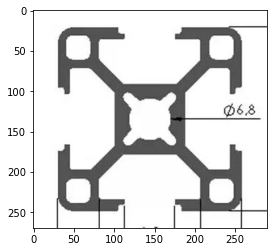

In [8]:
fov = imgRGB[10:280,20:310]
fov_gray=cv.cvtColor(fov, cv.COLOR_RGB2GRAY )

plt.figure("FOV")
plt.imshow(fov_gray,cmap='gray')
plt.show()

## Filtro gaussiano
+ Aplicamos un filtro gaussiano a la imagen equalizada para suavizar y desenfocar la imagen

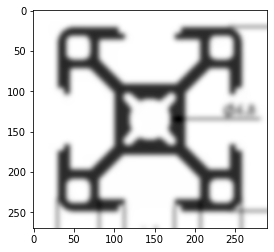

In [9]:
c = cv.GaussianBlur(fov_gray,(17,17),3)

plt.figure("Gaussiana")
plt.imshow(c,cmap="gray")
plt.show()

## Binarizacion Umbral Fijo
+ Binarizamos la imagen para luego utilizar la funcion findContours que provee Open CV

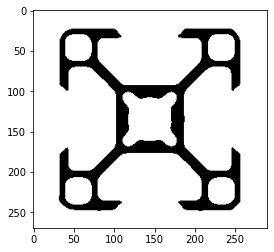

In [10]:
ret, img_bin = cv.threshold(c,130,255,cv.THRESH_BINARY)

plt.figure("Imagen Binarizada")
plt.imshow(img_bin,cmap='gray')
plt.show()

## Contornos
+ Hallamos los contornos de la imagen y mostramos cuantos se han encontrado.

In [11]:
#Para la función findContours dependiendo de la versión de opencv utilizada desempaqueta 2 o 3 datos.
contours, hierarchy = cv.findContours(img_bin, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

print("Cantidad de contornos encontrados: ", len(contours))

Cantidad de contornos encontrados:  7


In [12]:
i=0
bloques = []

for cnt in contours:
    area = cv.contourArea(cnt)
    #para eliminar ruidio tomamos areas mayores a 200
    if area > 200 and area < 50000:
        print('i:{} Área: {}'.format(i, area))
        bloques.append(cnt)    
    
    i+=1

i:1 Área: 21127.5
i:2 Área: 935.5
i:3 Área: 942.0
i:4 Área: 3230.5
i:5 Área: 936.5
i:6 Área: 929.5


+ Dibujamos los contornos y denominamos los bloques sobre una copia de la imagen fov

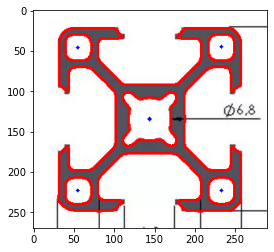

True

In [58]:
img_out1 = fov.copy()
i=1

for cnt in bloques:
    
    cv.drawContours(img_out1, [cnt], 0, (255,0,0), 2)
    #Centros de cada bloque
    M = cv.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    img_out1=cv.circle(img_out1, (cx,cy), radius=0, color=(0, 0, 255), thickness=4)

#img_out1=cv.circle(img_out1, (233,223), radius=0, color=(0, 0, 255), thickness=4)

plt.figure("Imagen 1 contornos")
plt.imshow(img_out1)
plt.show()

img_out1RGB = cv.cvtColor(img_out1, cv.COLOR_BGR2RGB)
cv.imwrite("Imagen-Contornos1.jpg", img_out1RGB)

## Parametros
+ Perimetro
+ Area
+ Orientacion
+ Relación de aspecto (largo Vs. ancho)

In [55]:
#Por regla de 3 calculo 1cm2 en píxeles

cm = 120/1.65
cm2= cm*cm #equivalente de cm2 en pixeles
cm4=cm**4
i=1


Jx=[]

for cnt in bloques:    
    
    # Perimetro
    p = cv.arcLength(cnt,False)
    p= p/cm #cm
    
    # Area
    area = cv.contourArea(cnt)
    area= area/cm2 #cm2
    
    #Momentos de inercia
    M = cv.moments(cnt)
    Mx= int(M["mu20"])/cm4
    Jx.append(Mx)
    My= int(M["mu02"])/cm4
    
    #Centros de cada bloque
    cx = int(M['m10']/M['m00'])/cm
    cy = int(M['m01']/M['m00'])/cm
        
    print('Bloque {} | Perimetro: {} - Área: {} - Jx: {} - Jy: {} - Cx: {} - Cy: {}'.format(i, '%.1f' % p,'%.1f' % area,'%.4f' % Mx,'%.4f' % My,'%.1f' % cx,'%.1f' % cy ))
    
    i+=1

Bloque 1 | Perimetro: 23.4 - Área: 4.0 - Jx: 3.6151 - Jy: 3.6542 - Cx: 2.0 - Cy: 1.9
Bloque 2 | Perimetro: 1.6 - Área: 0.2 - Jx: 0.0025 - Jy: 0.0025 - Cx: 3.2 - Cy: 3.1
Bloque 3 | Perimetro: 1.6 - Área: 0.2 - Jx: 0.0025 - Jy: 0.0026 - Cx: 0.8 - Cy: 3.1
Bloque 4 | Perimetro: 4.0 - Área: 0.6 - Jx: 0.0356 - Jy: 0.0357 - Cx: 2.0 - Cy: 1.8
Bloque 5 | Perimetro: 1.6 - Área: 0.2 - Jx: 0.0025 - Jy: 0.0025 - Cx: 3.2 - Cy: 0.6
Bloque 6 | Perimetro: 1.6 - Área: 0.2 - Jx: 0.0025 - Jy: 0.0025 - Cx: 0.8 - Cy: 0.6


# Verifico desplazamientos

+ Por principio de trabajos virtuales se tiene:
$$\delta = \int_0^{L} M \tilde{M} \frac{dx}{EJ}=\frac{1}{2}F\frac{L^3}{EJ}$$

In [53]:
#tomando un determinado valor de h y relación de aspecto

h=20 #cm
r=1.5
F=4*9.8 #N
L=120+2*h
J_total=Jx[0]-4*(Jx[1]+15665/cm2*0.2)-Jx[2]
E_aluminio=70*10**6 #N/cm2
delta=1/2*F*L**3/(J_total*E_aluminio)

print("El desplazamiento que sufriría el extremo de la barra es ", '%.2f' % delta,"cm")

El desplazamiento que sufriría el extremo de la barra es  0.93 cm


In [57]:
#Tomando sección transversal 2 perfiles unidos

J_union=2*(J_total + 2.6*1.5)

delta_union=1/2*F*L**3/(J_union*E_aluminio)

print("El desplazamiento que sufriría el extremo de la barra es ", '%.2f' % delta_union,"cm")

El desplazamiento que sufriría el extremo de la barra es  0.11 cm
